# Data processing and Inspection

In [53]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#student id for random seed
STUNDENT_ID = 404488

#data paths
dataset_path = 'UCI HAR/dataset.txt'
feature_path = 'UCI HAR/features.txt'
targets_path = 'UCI HAR/targets.txt'

In [54]:
#load data
df = pd.read_csv(dataset_path, sep=r'\s+', header=None)
features = pd.read_csv(feature_path, sep=r'\s+', header=None, names=['feature']).iloc[:, 0] 
targets = pd.read_csv(targets_path, header=None, names=['target'])
df.columns = features

In [55]:
#basic statistics
df.iloc[:, :10].describe()

feature,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
#basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(features)}")
print(f"Number of classes: {len(np.unique(targets))}")
print(f"Class distribution:\n{targets.value_counts()}")

Dataset shape: (10299, 561)
Number of features: 561
Number of classes: 6
Class distribution:
target
6         1944
5         1906
4         1777
1         1722
2         1544
3         1406
Name: count, dtype: int64


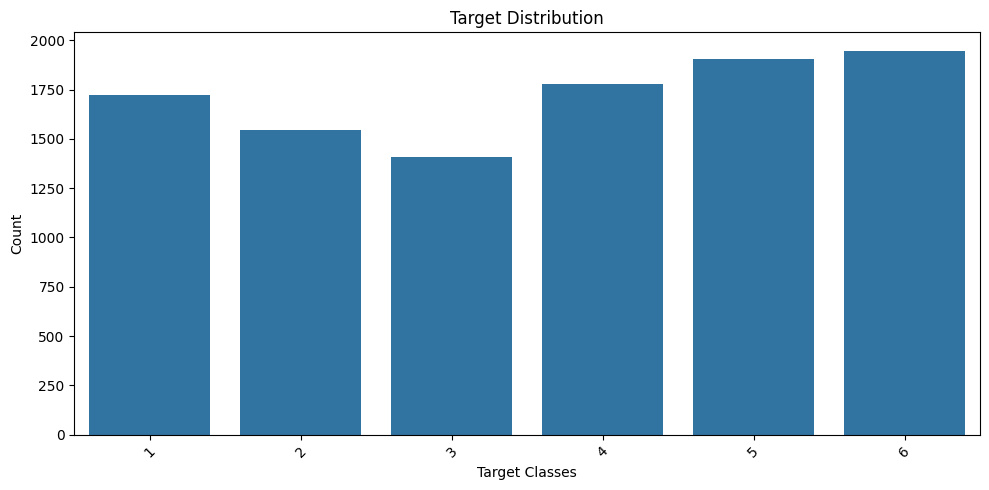

In [57]:
#plot target distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=targets["target"])
plt.title("Target Distribution")
plt.xlabel("Target Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

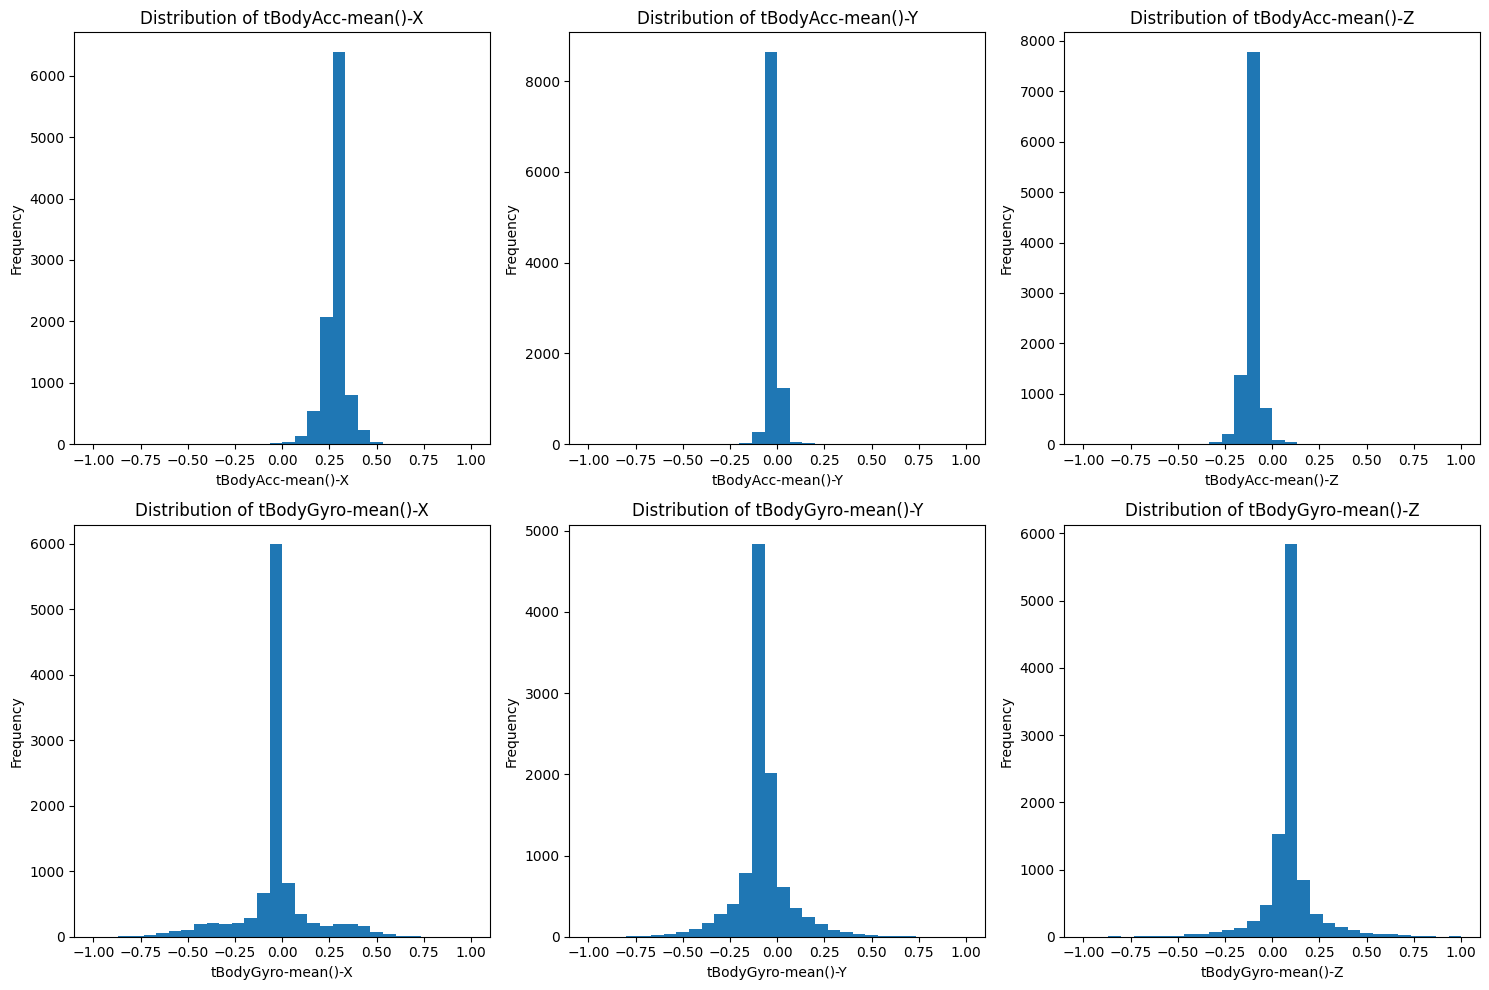

In [58]:
#distribution plots - histograms of a few selected features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']):
    plt.subplot(2, 3, i+1)
    plt.hist(df[feature], bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

for i, feature in enumerate(['tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z']):
    plt.subplot(2, 3, i+4)
    plt.hist(df[feature], bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

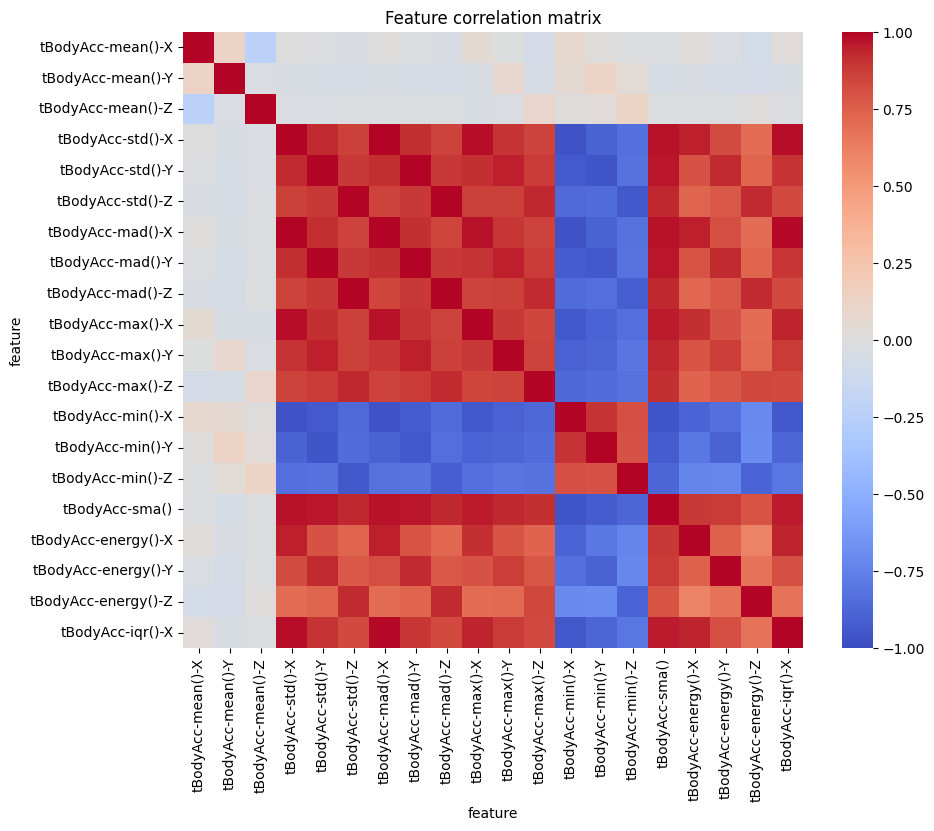

In [59]:
#correlation matrix first 20 features
corr_matrix = df.iloc[:, :20].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin = -1, vmax = 1, annot=False)
plt.title("Feature correlation matrix")
plt.show()

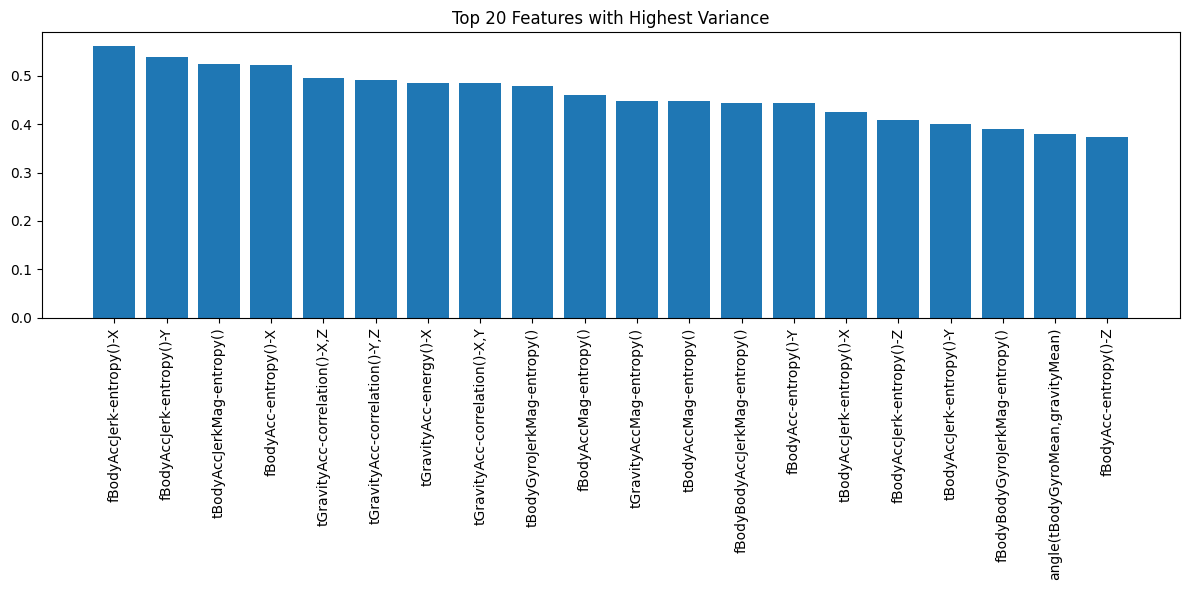

In [60]:
#feature variance
#calculate variance for features
feat_var = df.var()

#sort features by variance
sorted_var = feat_var.sort_values(ascending=False)

#plot top 20 features with highest variance
plt.figure(figsize=(12, 6))
plt.bar(range(20), sorted_var[:20].values)
plt.xticks(range(20), sorted_var[:20].index, rotation=90)
plt.title("Top 20 Features with Highest Variance")
plt.tight_layout()
plt.show()

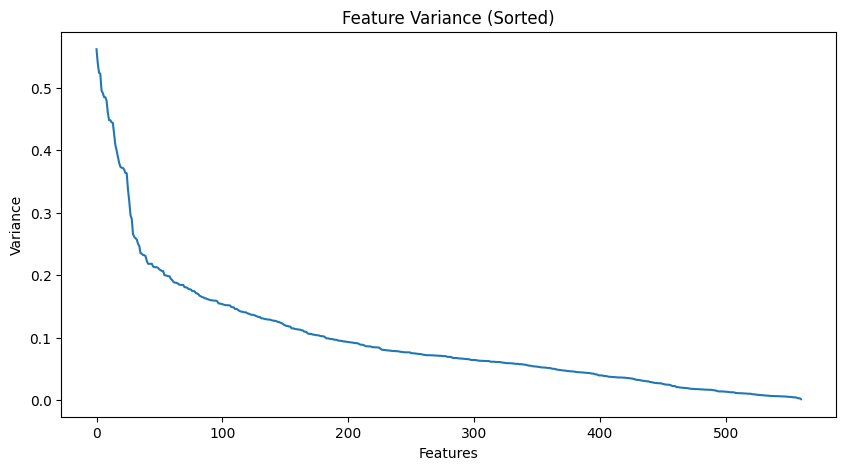

In [61]:
#plot variance distribution
plt.figure(figsize=(10, 5))
plt.plot(sorted_var.values)
plt.title("Feature Variance (Sorted)")
plt.xlabel("Features")
plt.ylabel("Variance")
plt.show()

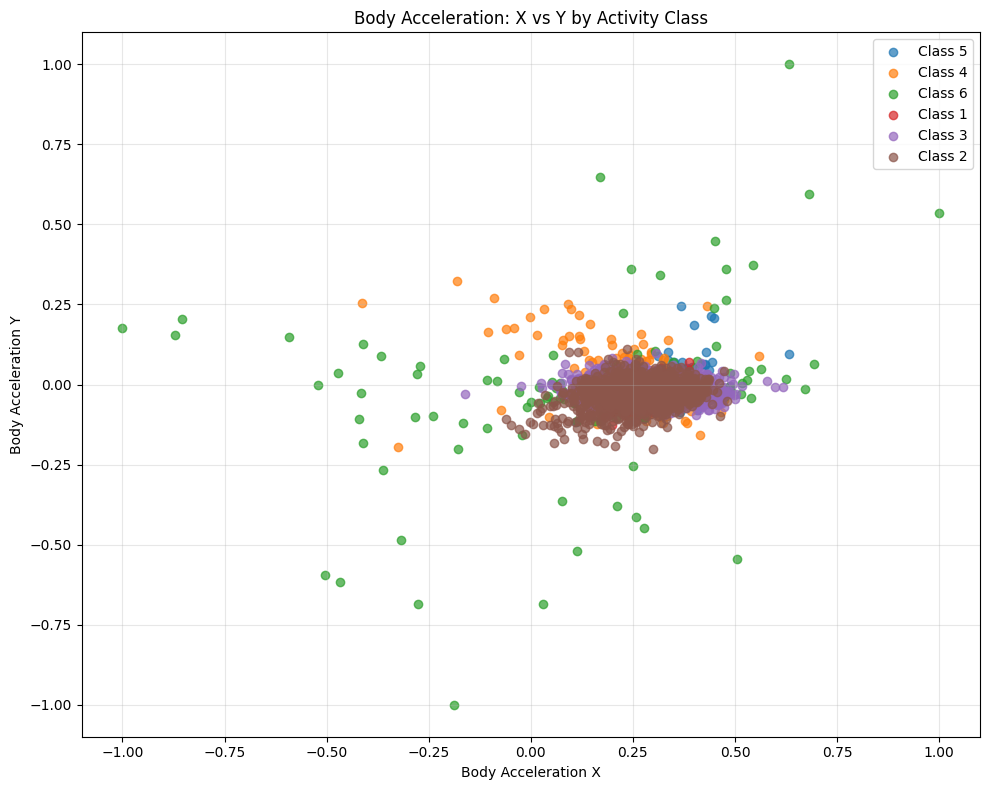

In [62]:
#scatter plot of two features, colored by target
plt.figure(figsize=(10, 8))
scatter_data = df[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y']].copy()
scatter_data['target'] = targets['target'].values

#create a scatter plot
for target_value in scatter_data['target'].unique():
    subset = scatter_data[scatter_data['target'] == target_value]
    plt.scatter(subset['tBodyAcc-mean()-X'], subset['tBodyAcc-mean()-Y'], 
                label=f'Class {target_value}', alpha=0.7)

plt.title('Body Acceleration: X vs Y by Activity Class')
plt.xlabel('Body Acceleration X')
plt.ylabel('Body Acceleration Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

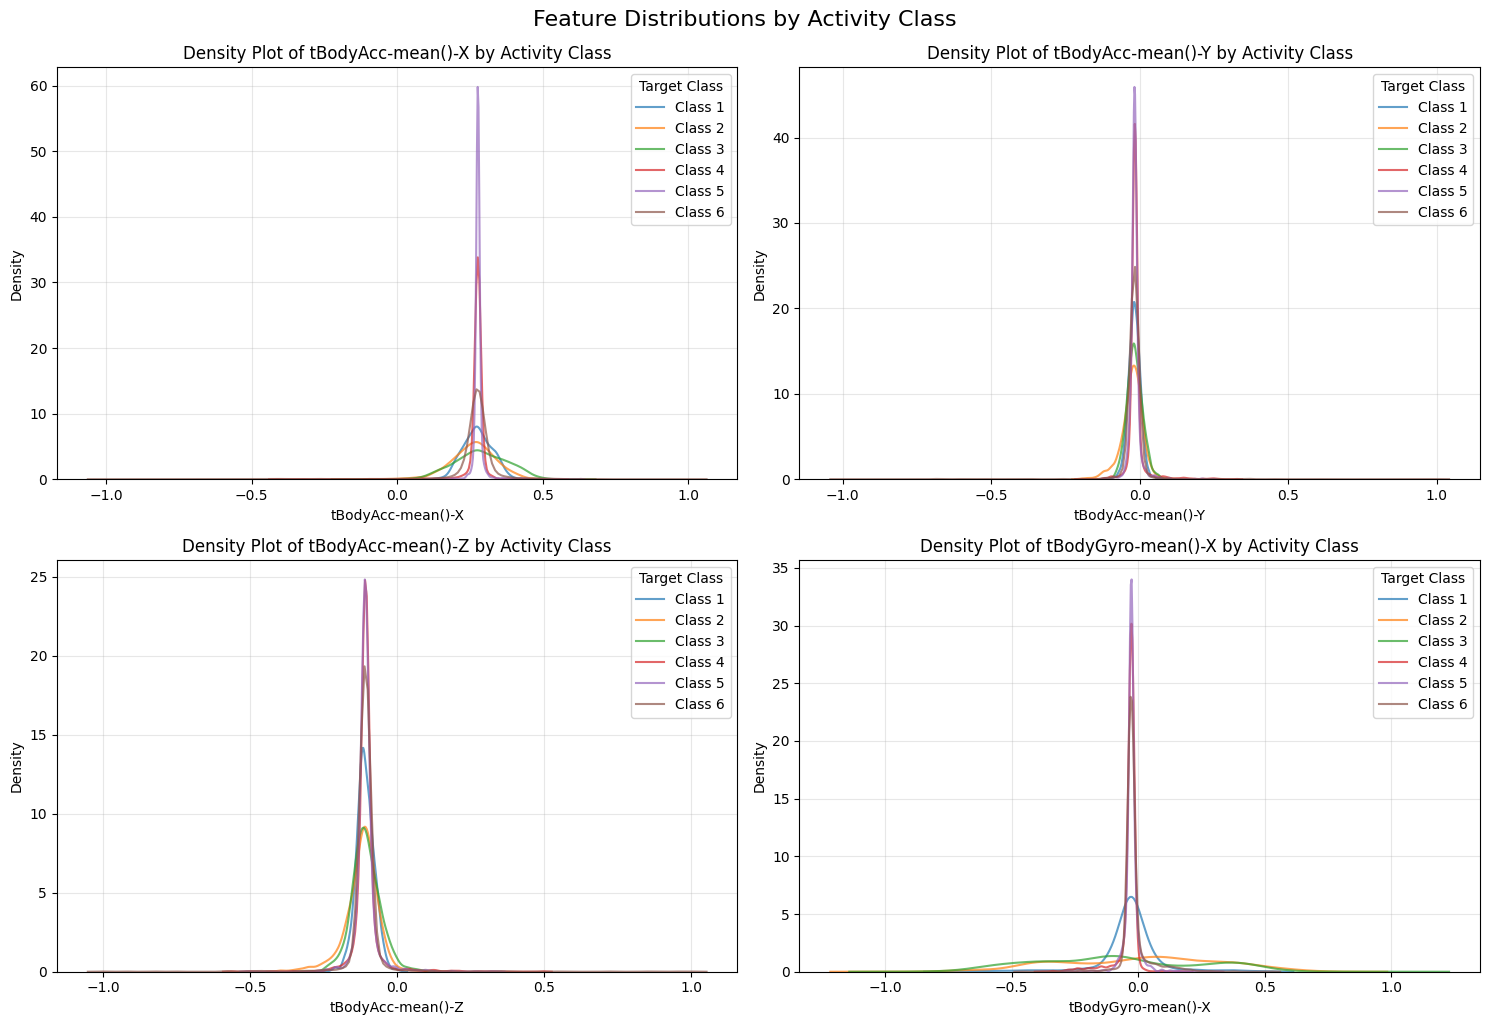

In [63]:
#density plots - improved version
plt.figure(figsize=(15, 10))

#create a 2x2 grid of density plots for different acceleration features
features_to_plot = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyGyro-mean()-X']

for idx, feature in enumerate(features_to_plot):
      plt.subplot(2, 2, idx+1)
      
      for target_class in np.unique(targets['target']):
            # Select rows for current target class
            class_indices = targets[targets['target'] == target_class].index
            # Plot density for this class
            sns.kdeplot(df.loc[class_indices, feature], 
                              label=f'Class {target_class}', alpha=0.7)
      
      plt.title(f'Density Plot of {feature} by Activity Class')
      plt.xlabel(feature)
      plt.ylabel('Density')
      plt.legend(title='Target Class')
      plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Feature Distributions by Activity Class", fontsize=16, y=1.02)
plt.show()


In [64]:
#train random forest to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=STUNDENT_ID)
rf.fit(df, targets.values.ravel())

#extract feature importances
feature_importances = np.array(rf.feature_importances_)
#get 100 most important features
important_features = df.columns[np.argsort(feature_importances)[-100:]]

#create a new dataframe with only the most important features
df_important = df[important_features]

In [ ]:
#split into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(df_important, targets.values.ravel(), test_size=0.3, random_state=STUNDENT_ID)

# Training models
Logistic Regression, 
Random Forest and 
SVM 

In [66]:
#standardise the data (important for SVM and logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
#logistic regression
lr = LogisticRegression(max_iter=1000, random_state=STUNDENT_ID)
lr.fit(X_train_scaled, y_train)

y_pred_log = lr.predict(X_test_scaled)
log_acc = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {log_acc}")

C:\Users\keith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy: 0.962135922330097


In [68]:
#random forest
rf = RandomForestClassifier(n_estimators=100, random_state=STUNDENT_ID)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc}")

C:\Users\keith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.9763754045307443


In [69]:
#SVM
svm = SVC(kernel='rbf', C=1.0, random_state=STUNDENT_ID)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc}")

C:\Users\keith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.9546925566343042


# Cross validation

In [ ]:
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
svm_cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)

print(f"Logistic Regression CV Scores: {np.mean(lr_cv_scores)}")
print(f"Random Forest CV Scores: {np.mean(rf_cv_scores)}")
print(f"SVM CV Scores: {np.mean(svm_cv_scores)}")

C:\Users\keith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\keith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\keith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

Logistic Regression CV Scores: 0.9632406798715255
Random Forest CV Scores: 0.9739222165220831
SVM CV Scores: 0.9572755858978346
